Осоргин Иван БКЛ211

Пометка: populate.ipynb не смотреть. Я хотел на своём датасете сделать, но оно не успеет посчитаться до дедлайна. Так что сдаю по дефолтным данным глагола "играть" (HW2_igrat)

In [1]:
!pip3 install numpy gensim wget
!pip3 install scipy matplotlib
!pip3 install scikit-learn

# Шаг 0 - подготовка и загрузка

In [2]:
import logging
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

In [3]:
# LOADING DATA
data = {}
data['verb'] = None
data['nouns'] = {}
with open('HW2_igrat\'.txt', 'r', encoding='utf-8') as f:
    for line in f:
        pair, count = line.strip().split('\t')
        data['verb'], noun = pair.split('_')
        data['nouns'][noun] = int(count)
data

{'verb': 'играть',
 'nouns': {'роль': 3121,
  'музыка': 614,
  'ребенок': 335,
  'оркестр': 331,
  'актер': 238,
  'человек': 183,
  'время': 164,
  'карта': 35,
  'музыкант': 131,
  'солнце': 120,
  'дитя': 109,
  'спектакль': 105,
  'комедия': 104,
  'жизнь': 102,
  'игра': 97,
  'артист': 93,
  'мальчик': 92,
  'свадьба': 89,
  'женщина': 73,
  'день': 71,
  'песня': 64,
  'девочка': 63,
  'вечер': 62,
  'пьеса': 62,
  'вальс': 61,
  'команда': 57,
  'улыбка': 57,
  'ребята': 55,
  'актриса': 53,
  'ветер': 53,
  'мальчишка': 51,
  'шахматы': 50,
  'гамлет': 48,
  'возможность': 47,
  'раз': 44,
  'песнь': 42,
  'год': 42,
  'румянец': 42,
  'рука': 42,
  'отец': 41,
  'россия': 40,
  'ночь': 40,
  'желание': 40,
  'футбол': 40,
  'сцена': 38,
  'судьба': 38,
  'мужчина': 37,
  'театр': 37,
  'мать': 36,
  'девушка': 35,
  'свет': 35,
  'джаз': 34,
  'ребятишки': 33,
  'скрипка': 33,
  'деньги': 33,
  'гармонь': 32,
  'шопен': 32,
  'прятки': 31,
  'лицо': 31,
  'луч': 30,
  'гость'

In [4]:
# DOWNLOADING MODEL
import wget
from zipfile import ZipFile
from pathlib import Path

model_url = "http://vectors.nlpl.eu/repository/20/220.zip"
model_zip = Path(model_url.split('/')[-1])
model_file = Path('model.bin')

if not model_zip.is_file():
    logging.info("Model is missing, downloading...")
    wget.download(model_url)
with ZipFile(model_zip, 'r') as archive:
    archive.extract('model.bin')

In [5]:
# LOADING MODEL
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(model_file, binary=True)

2024-02-17 21:59:03,861 [INFO] loading projection weights from model.bin
2024-02-17 21:59:07,957 [INFO] KeyedVectors lifecycle event {'msg': 'loaded (249333, 300) matrix of type float32 from model.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-02-17T21:59:07.957002', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-5.15.0-92-generic-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}


# Шаг 1
Извлечь вектор для глагола и каждого существительного из списка

In [6]:
import numpy as np
verb_vec = np.array(model[f"{data['verb']}_VERB"])
noun_vecs = np.array([ model[f'{n}_NOUN'] for n in data['nouns'] ])

# Шаг 2
Сделать пары глагол + сущ

In [7]:
vec_sums = noun_vecs + verb_vec
# на всякий случай проверяю что сумма правильно посчиталась...
for i in range(len(vec_sums)):
    for j in range(len(vec_sums[i])):
        if vec_sums[i][j] != noun_vecs[i][j] + verb_vec[j]:
            print('NOOO')
            break

# Шаг 3
Кластеризовать все векторные представления пар двумя способами

## Иерархическая кластеризация

In [8]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster

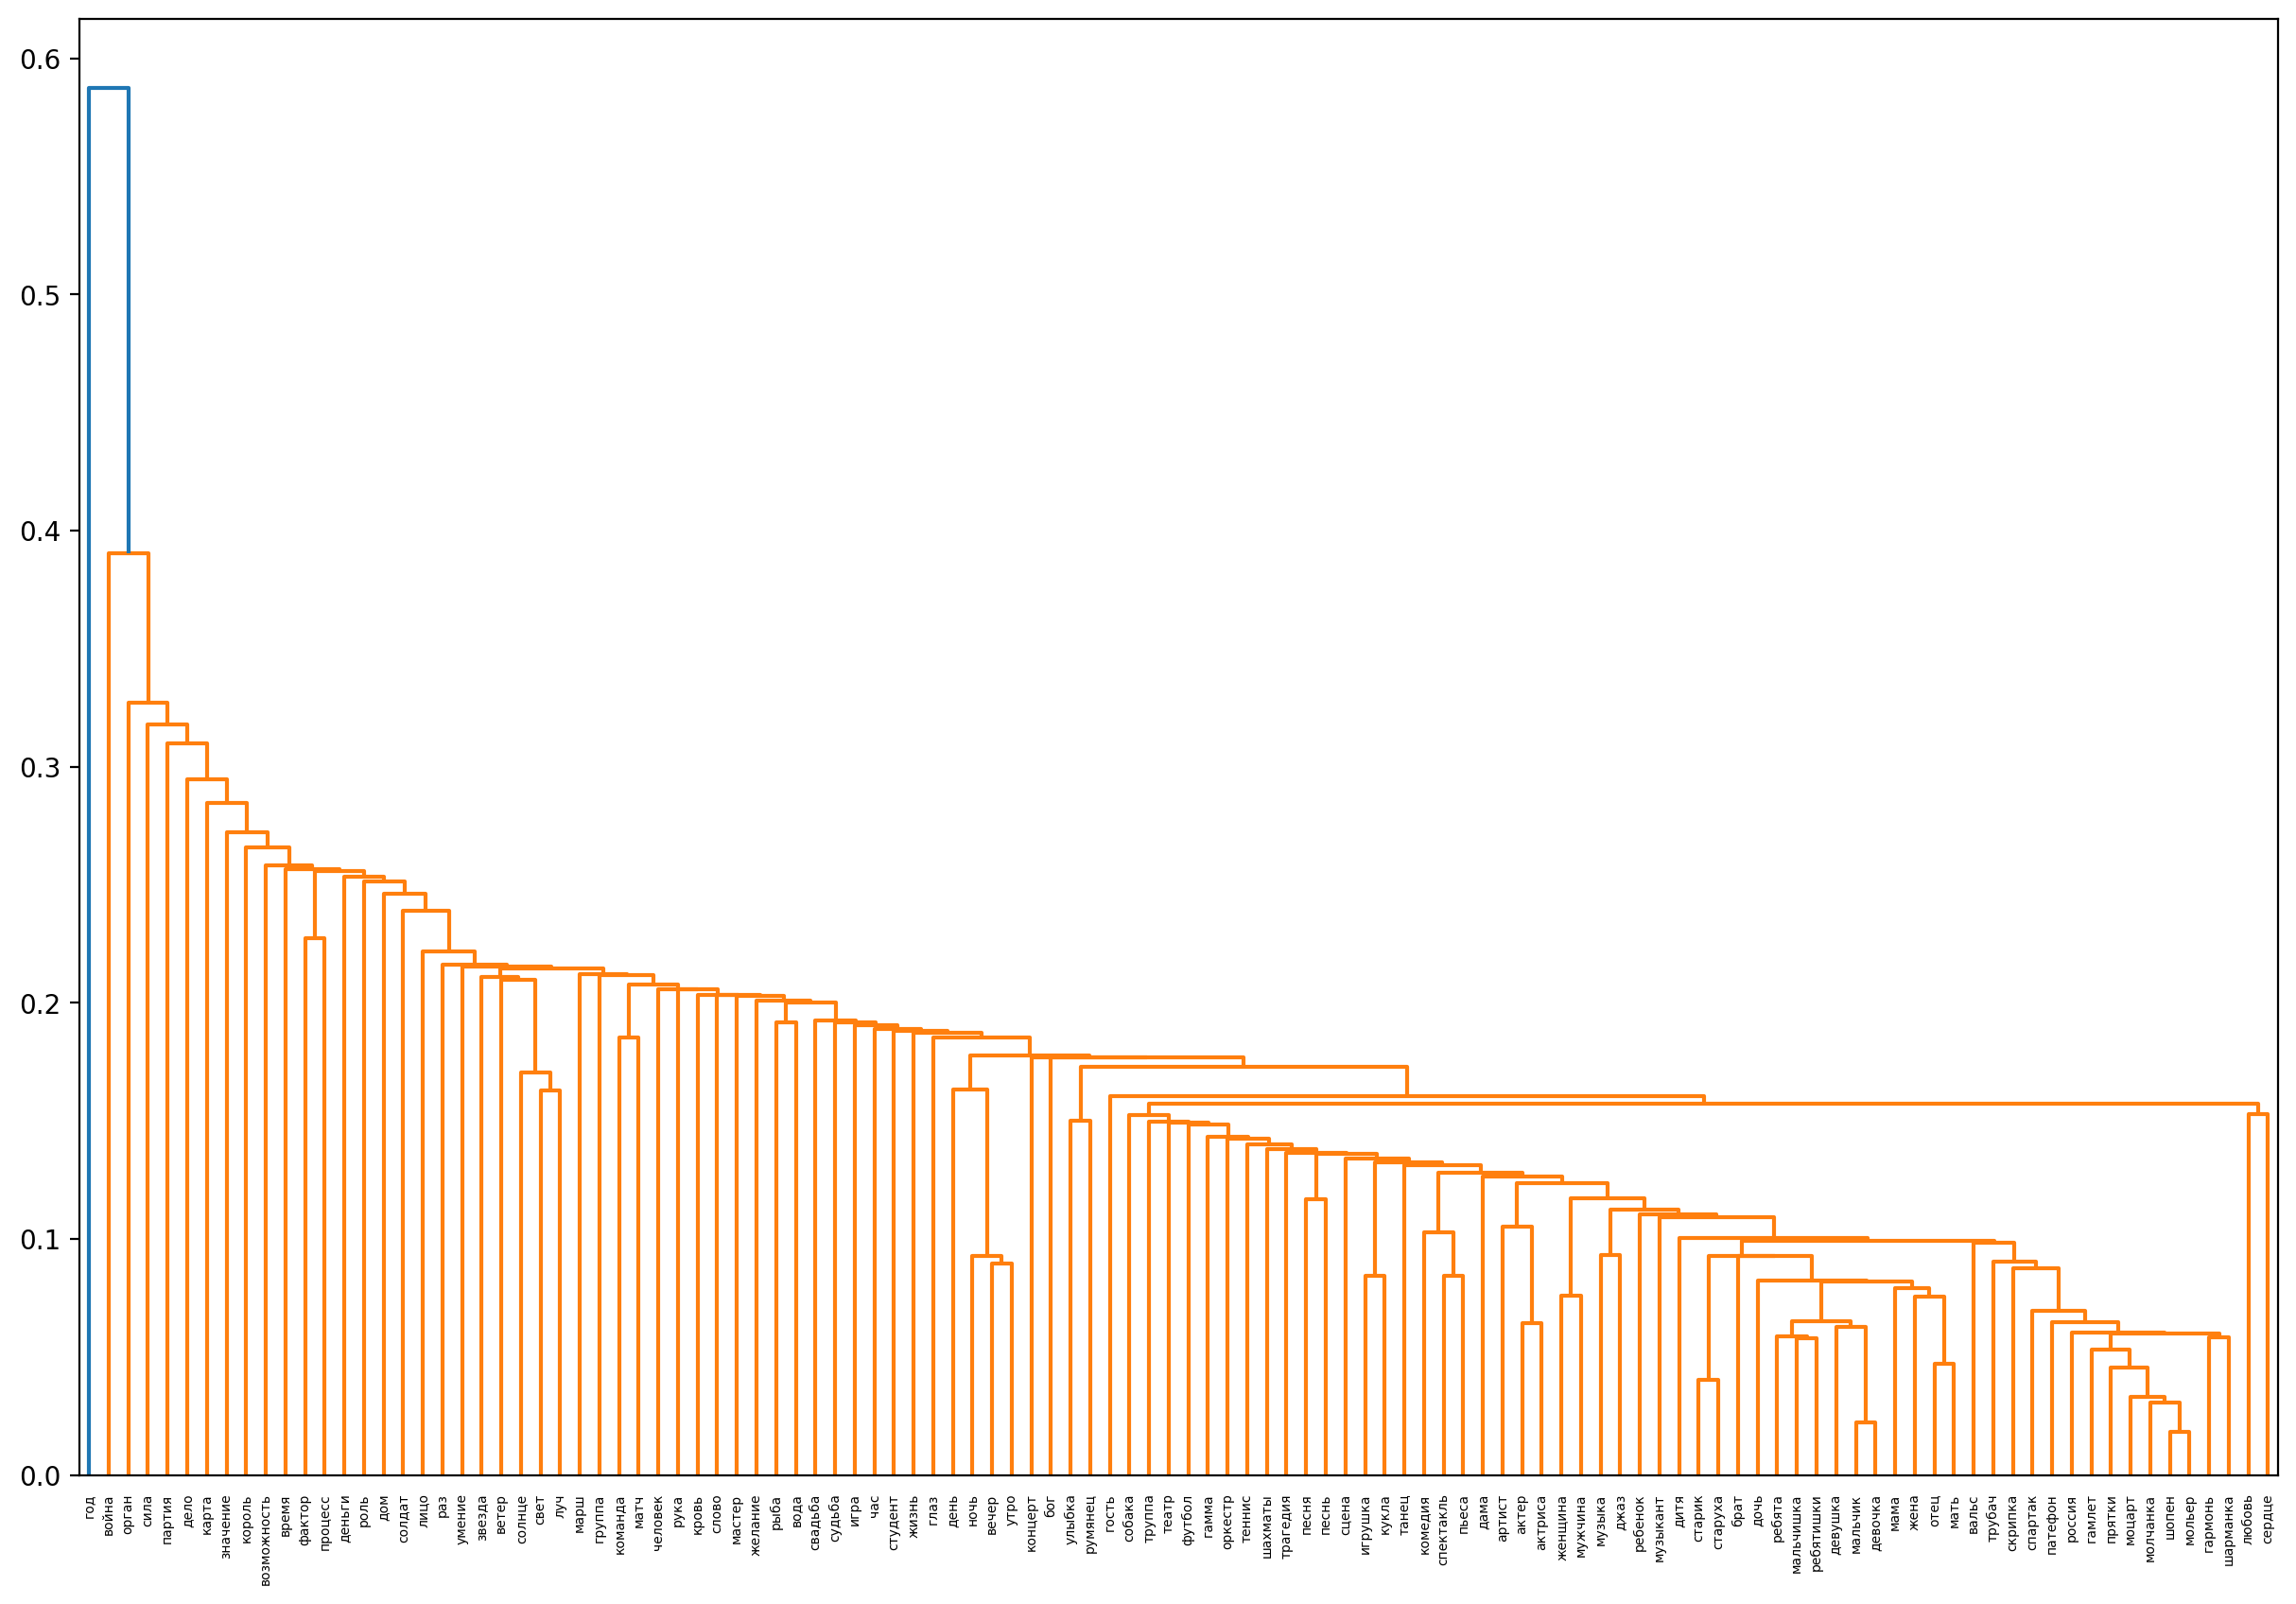

In [9]:
Z = hcluster.linkage(vec_sums, metric='cosine')
plt.figure(figsize=(15, 10), dpi=200)
dn = hcluster.dendrogram(Z, labels=list(data['nouns'].keys()))
plt.show()

In [10]:
from typing import List, Tuple
MIN_CL_SIZE = 3

clusters = hcluster.fcluster(Z, 0.8)
# making convinient(?) cluster collection
# list of clusters. Cluster items are tuples[word(str), vector(ndarray)]
word_clusters: List[List[Tuple[str, np.ndarray]]] = \
    [ list() for _ in range(len(set(clusters))) ]
print(f'Estimated number of clusters: {len(word_clusters)}')
# populating cluster collection
for cl_id, word, vec in zip(clusters, data['nouns'].keys(), vec_sums):
    word_clusters[cl_id - 1].append((word, vec))
# filtering out small clusters
word_clusters = [ x for x in word_clusters if len(x) >= MIN_CL_SIZE ]
print(f'Estimated number of clusters with size >= {MIN_CL_SIZE}: {len(word_clusters)}')

word_clusters.sort(key=lambda x: len(x))
# displaying words only
for l in word_clusters:
    print([ w[0] for w in l ])

Estimated number of clusters: 71
Estimated number of clusters with size >= 3: 8
['спектакль', 'комедия', 'пьеса']
['актер', 'артист', 'актриса']
['ребята', 'мальчишка', 'ребятишки']
['мальчик', 'девочка', 'девушка']
['день', 'вечер', 'ночь', 'утро']
['отец', 'мать', 'мама', 'жена']
['солнце', 'ветер', 'свет', 'луч', 'звезда']
['вальс', 'гамлет', 'россия', 'скрипка', 'гармонь', 'шопен', 'прятки', 'трубач', 'моцарт', 'спартак', 'шарманка', 'молчанка', 'патефон', 'мольер']


## Кластеризация K-Means

In [11]:
CL_N = 9

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=CL_N, random_state=512).fit(vec_sums)

word_clusters: List[List[Tuple[str, np.ndarray]]] = \
    [ list() for _ in range(CL_N) ]

for cl_id, word, vec in zip(kmeans.labels_, data['nouns'].keys(), vec_sums):
    word_clusters[cl_id - 1].append((word, vec))

for l in word_clusters:
    print(sorted([ w[0] for w in l ]))

['ветер', 'вечер', 'день', 'ночь', 'солнце', 'утро', 'час']
['игра', 'команда', 'матч', 'теннис', 'футбол', 'шахматы']
['вода', 'возможность', 'гамма', 'значение', 'луч', 'орган', 'процесс', 'рыба', 'свет', 'фактор']
['брат', 'дама', 'девочка', 'девушка', 'дитя', 'дом', 'дочь', 'жена', 'женщина', 'король', 'мальчик', 'мама', 'мать', 'мужчина', 'отец', 'ребенок', 'свадьба', 'старик', 'старуха']
['год']
['артист', 'джаз', 'концерт', 'музыка', 'музыкант', 'оркестр', 'песня', 'пьеса', 'спектакль', 'сцена', 'танец', 'театр', 'труппа']
['бог', 'глаз', 'дело', 'желание', 'жизнь', 'кровь', 'лицо', 'любовь', 'рука', 'сердце', 'сила', 'слово', 'судьба', 'улыбка', 'умение', 'человек']
['вальс', 'война', 'время', 'гамлет', 'гармонь', 'гость', 'группа', 'деньги', 'звезда', 'игрушка', 'карта', 'кукла', 'мальчишка', 'марш', 'мастер', 'молчанка', 'мольер', 'моцарт', 'партия', 'патефон', 'песнь', 'прятки', 'раз', 'ребята', 'ребятишки', 'россия', 'румянец', 'скрипка', 'собака', 'солдат', 'спартак', 'сту

### 3 ближайших к центру слова

In [12]:
N_CLOSEST = 3

center_words = []

from scipy.spatial import distance
for cluster, center in zip(word_clusters, kmeans.cluster_centers_):
    dist_list = []
    if len(cluster) < N_CLOSEST: continue
    for word, vec in cluster:
        cos_dist = distance.cosine(center, vec)
        dist_list.append((cos_dist, word))
    dist_list.sort()
    center_words.append(dist_list[:N_CLOSEST])
    print(f'Closest {N_CLOSEST} to center: {dist_list[:N_CLOSEST]}\n{[x[0] for x in cluster]}')

Closest 3 to center: [(0.274601843184189, 'вечер'), (0.337565690488821, 'солнце'), (0.3395117859186122, 'ночь')]
['солнце', 'день', 'вечер', 'ветер', 'ночь', 'час', 'утро']
Closest 3 to center: [(0.28569355307267963, 'шахматы'), (0.29627729305799455, 'теннис'), (0.3107766602176508, 'игра')]
['игра', 'команда', 'шахматы', 'футбол', 'теннис', 'матч']
Closest 3 to center: [(0.23614440707069007, 'гамма'), (0.3032177312048796, 'рыба'), (0.32192371138300757, 'луч')]
['возможность', 'свет', 'луч', 'гамма', 'орган', 'фактор', 'рыба', 'значение', 'вода', 'процесс']
Closest 3 to center: [(0.16914304732751495, 'дитя'), (0.18323377838685606, 'старуха'), (0.18883586339252667, 'старик')]
['ребенок', 'дитя', 'мальчик', 'свадьба', 'женщина', 'девочка', 'отец', 'мужчина', 'мать', 'девушка', 'король', 'мама', 'старик', 'жена', 'дама', 'брат', 'дом', 'дочь', 'старуха']
Closest 3 to center: [(0.6687769861337629, 'труппа'), (0.7090029528546629, 'оркестр'), (0.7092465708621849, 'музыкант')]
['музыка', 'орке

In [13]:
sorted_centers = sorted(center_words, key=lambda l: sum(x[0] for x in l))
[ [ f"{data['verb']}_{w[1]}" for w in c ] for c in sorted_centers ]

[['играть_шопен', 'играть_мольер', 'играть_молчанка'],
 ['играть_актер', 'играть_актриса', 'играть_комедия'],
 ['играть_дитя', 'играть_старуха', 'играть_старик'],
 ['играть_любовь', 'играть_слово', 'играть_улыбка'],
 ['играть_гамма', 'играть_рыба', 'играть_луч'],
 ['играть_шахматы', 'играть_теннис', 'играть_игра'],
 ['играть_вечер', 'играть_солнце', 'играть_ночь'],
 ['играть_труппа', 'играть_оркестр', 'играть_музыкант']]

# Шаг 6
Анализ результатов

Большинство групп, такиех как "играть_актер/актриса/комедия" или "играть_шахматы/теннис/игра", кажутся довольно однородными в своих тематиках. Но, например, в группе "играть_гамма/рыба/луч", может показаться менее ясным, как связаны между собой слова. Думаю, получилось вполне объемлюще поймать разные смыслы глаглола "играть", хотя значения типа "играть мертвого, играть больного" или "играть [c] котом" (играться с животными/детьми) не всплыли здесь, как и некоторые другие вероятно. 